In [35]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
import scipy
import numpy as np

# For benchmarking
import time
from scipy.integrate import nquad

# For plotting
import matplotlib.pyplot as plt

# To avoid copying things to GPU memory,
# ideally allocate everything in torch on the GPU
# and avoid non-torch function calls
import torch
torch.set_printoptions(precision=10) # Set displayed output precision to 10 digits

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS # The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad

In [3]:
kB = 8.61733e-5 # eV / K
me_c2 = 510998.92 # eV
h = 4.13567e-15 # eV s

In [63]:
def Ne(gamma, Te, gamma_th, Ce=1, n=3):
    Te = torch.tensor([Te])
    gamma_th = torch.tensor(gamma_th)
    #gamma = torch.tensor(gamma)
    Ce = torch.tensor(Ce)
    n = torch.tensor(n)

    Theta = kB * Te / me_c2

    Ne_tensor = torch.zeros_like(gamma)

    for i, i_gamma in enumerate(gamma):
        Ne_tensor[i] = Ce*i_gamma**2*torch.exp(-i_gamma/Theta)/(2.*Theta**3) if i_gamma <= gamma_th else Ce*gamma_th**2*torch.exp(-gamma_th/Theta)*(i_gamma/gamma_th)**-n/(2.*Theta**3)

    return Ne_tensor

def beta(gamma):
    return torch.sqrt(1 - 1/gamma**2)

def e1(nu,theta,theta2,gamma,phi2):

    #nu = torch.tensor(nu)
    theta = torch.tensor(theta)
    #theta2 = torch.tensor(theta2)
    #gamma = torch.tensor(gamma)
    #phi2 = torch.tensor(phi2)
    
    e0 = h*nu#*1e-3 #keV
    cos_theta1 = torch.cos(theta)*torch.cos(theta2)+torch.sin(theta)*torch.sin(theta2)*torch.sin(phi2)
    
    return e0*(1-beta(gamma)*torch.cos(theta2))/(e0/(gamma*me_c2)*(1-torch.cos(theta))+1-beta(gamma)*cos_theta1)

In [68]:
gamma = torch.logspace(1, 2, 25)
nu = torch.logspace(13, 16, 25)

In [60]:
Te=widgets.FloatSlider(description='Te',min=1e8, max=1e11, step=1e8, value=1e10)
gamma_th=widgets.FloatSlider(description='gamma_th',min=1, max=100, step=1, value=20)
ui = widgets.VBox([Te, gamma_th])

def electron_dist_img(Te, gamma_th):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)

    Ne_tensor = Ne(gamma, Te=Te, gamma_th=gamma_th)
    ax.plot(gamma, Ne_tensor,label=f'$T_\mathrm{{e}} = 10^{{{np.log10(Te):.1f}}}$ K')

    ax.axvline(gamma_th, color='k', linestyle='--', label=r'$\gamma_\mathrm{th}$')

    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$N_\mathrm{e}/C_\mathrm{e}$')
    ax.set_yscale('log')
    ax.set_ylim(1e-13, 1e2)
    ax.legend()

out = widgets.interactive_output(electron_dist_img, {'Te': Te, 'gamma_th': gamma_th})
display(ui, out)

Output()

In [75]:
Te=widgets.FloatSlider(description='Te',min=1e8, max=1e11, step=1e8, value=1e10)
gamma_th=widgets.FloatSlider(description='gamma_th',min=1, max=100, step=1, value=20)
#nu=widgets.FloatSlider(description='nu',min=1e13, max=1e16, step=1e13, value=1e15)
theta=widgets.FloatSlider(description='theta',min=0, max=np.pi, step=np.pi/16, value=np.pi/4)
#theta2=widgets.FloatSlider(description='theta2',min=0, max=np.pi, step=np.pi/16, value=np.pi/4)
#phi2=widgets.FloatSlider(description='phi2',min=0, max=2*np.pi, step=np.pi/16, value=np.pi/4)

ui = widgets.VBox([Te, gamma_th, theta])

def calc_img(Te, gamma_th, theta):

    #e1_mean = func(theta2,phi2,nu,theta, Te, gamma_th,gamma)

    fig = plt.figure(dpi=100,figsize=(15,5))
    ax1 = fig.add_subplot(121)

    Ne_tensor = Ne(gamma, Te=Te, gamma_th=gamma_th)
    ax1.plot(gamma, Ne_tensor,label=rf'$T_\mathrm{{e}} = 10^{{{np.log10(Te):.2f}}}$ K')

    ax1.axvline(gamma_th, color='k', linestyle='--', label=rf'$\gamma_\mathrm{{th}} = {gamma_th:.1f}$')

    ax1.set_xlabel(r'$\gamma$')
    ax1.set_ylabel(r'$N_\mathrm{e}/C_\mathrm{e}$')
    ax1.set_yscale('log')
    #ax1.set_ylim(1e-13, 1e2)
    ax1.legend()


    ax2 = fig.add_subplot(122)

    final_value = []
    for i_nu in nu:
        function_values, _ = integrator.evaluate_integrand(lambda x: integrand(x,Te=Te,gamma_th=gamma_th,nu=i_nu,theta=theta), grid_points)
        integral1 = integrator.calculate_result(function_values, dim, n_per_dim, hs, integration_domain)

        function_values, _ = integrator.evaluate_integrand(lambda x: integrand2(x,Te=Te,gamma_th=gamma_th), grid_points)
        integral2 = integrator.calculate_result(function_values, dim, n_per_dim, hs, integration_domain)

        final_value.append(integral1/(4*np.pi*integral2))

    ax2.plot(nu, final_value,label=fr'$T_\mathrm{{e}} = 10^{{{np.log10(Te):.2f}}} K, \gamma_\mathrm{{th}} = {gamma_th:.1f}, \theta = {theta:.1f}\,\mathrm{{rad}}$')

    #ax.axvline(gamma_th, color='k', linestyle='--', label=r'$\gamma_\mathrm{th}$')
    ax2.set_xlabel(r'$\nu$')
    ax2.set_ylabel(r'$<e1>$')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    #ax2.set_ylim(1e-13, 1e2)
    ax2.legend()

out = widgets.interactive_output(calc_img, {'Te': Te, 'gamma_th': gamma_th, 'theta':theta})
display(ui, out)

#
#
#np.sum(val)

#@latexify.function(use_math_symbols=True,reduce_assignments=True)
#def mean_e1(nu, theta):
#    return quadpy.quad(e1, 0, 2*np.pi, args=(theta,theta,gamma,0))
#mean_e1

#def calc_img(Te, gamma_th, nu, theta):
#    print(Te, gamma_th, nu, theta)
    #val = scheme.integrate_spherical(func,)
    #print(val)

# out = widgets.interactive_output(calc_img, {'Te': Te, 'gamma_th': gamma_th, 'nu':nu, 'theta':theta})
# display(ui, out)

Output()

In [11]:
def func(theta2_phi2,nu,theta,i_gamma):
    theta2, phi2 = theta2_phi2
    #val, error_estimate = quadpy.c1.integrate_adaptive(
    #    lambda i_gamma: Ne(i_gamma,Te=Te,gamma_th=gamma_th)*e1(nu,theta,theta2,#i_gamma,phi2) , [1, 10]
    #)
    return e1(nu,theta,theta2,i_gamma,phi2)

In [12]:
def func(theta2_phi2,x):
    theta2, phi2 = theta2_phi2
    #val, error_estimate = quadpy.c1.integrate_adaptive(
    #    lambda i_gamma: Ne(i_gamma,Te=Te,gamma_th=gamma_th)*e1(nu,theta,theta2,#i_gamma,phi2) , [1, 10]
    #)
    #print(theta2.shape)
    return x*np.linspace(0,1,theta2.shape[0])*np.sin(theta2)
#val = scheme.integrate_spherical(func)
#val

In [28]:
# Use this to enable GPU support and set the floating point precision
set_up_backend("torch", data_type="float32")

14:49:39|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


In [54]:
real = 4/3*np.pi

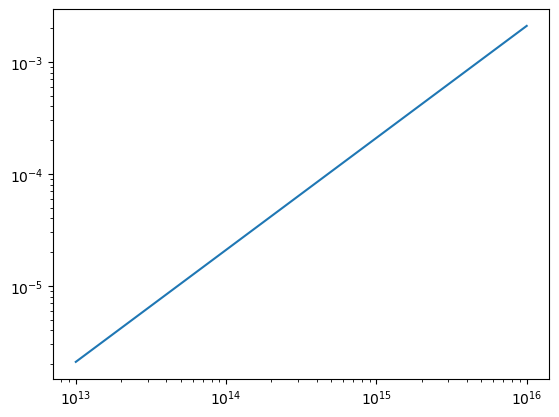

In [37]:
import torch
from torchquad import Boole

def integrand(x,Te,gamma_th,nu,theta):
    # gamma x[:,0]
    # theta2 x[:,1]
    # phi2 x[:,2]
    return Ne(x[:,0], Te, gamma_th)*e1(nu,theta,x[:,1],x[:,0],x[:,2])*torch.sin(x[:,1])

def integrand2(x,Te,gamma_th):
    return Ne(x[:,0], Te, gamma_th)

# The integration domain, dimensionality and number of evaluations
# For the calculate_grid method we need a Tensor and not a list.
integration_domain = torch.Tensor([[1., 100.], 
                                   [0., np.pi], 
                                   [0., 2*np.pi]])
dim = 3
N = 1024

# Initialize the integrator
integrator = Simpson()
# Calculate sample points and grid information for the result calculation
grid_points, hs, n_per_dim = integrator.calculate_grid(N, integration_domain)

# Integrate the first integrand with the sample points
final_value = []
for i_nu in nu:
    function_values, _ = integrator.evaluate_integrand(lambda x: integrand(x,Te=1e8,gamma_th=20,nu=i_nu,theta=np.pi/4), grid_points)
    integral1 = integrator.calculate_result(function_values, dim, n_per_dim, hs, integration_domain)

    function_values, _ = integrator.evaluate_integrand(lambda x: integrand2(x,Te=1e8,gamma_th=20), grid_points)
    integral2 = integrator.calculate_result(function_values, dim, n_per_dim, hs, integration_domain)

    final_value.append(integral1/(4*np.pi*integral2))
plt.plot(nu, final_value)
plt.xscale('log')
plt.yscale('log')

In [53]:
vegas = VEGAS()
result = vegas.integrate(lambda x: integrand(x,Te=1e8,gamma_th=20,theta=np.pi/4), dim=dim, N=N, integration_domain=integration_domain)
print(result,(result-real)/real*100,'%')

RuntimeError: The size of tensor a (384) must match the size of tensor b (81) at non-singleton dimension 0

4.1887902047863905

In [48]:
result

tensor(4.1790060997)

In [34]:
def parametrized_integrand(x, a, b):
    return torch.sqrt(torch.cos(torch.sin((a + b) * x)))

a_params = torch.arange(40)
b_params = torch.arange(10, 20)
integration_domain = torch.Tensor([[0, 1]])
simp = Simpson()
result = torch.stack([torch.Tensor([simp.integrate(lambda x: parametrized_integrand(x, a, b), dim=1, N=101, integration_domain=integration_domain) for a in a_params]) for b in b_params])

In [35]:
grid = torch.stack([torch.Tensor([a + b for a in a_params]) for b in b_params])

def integrand(x):
    return torch.sqrt(torch.cos(torch.sin(torch.einsum("i,jk->ijk", x.flatten(), grid))))

result_vectorized = simp.integrate(integrand, dim=1, N=101, integration_domain=integration_domain)

torch.all(torch.isclose(result_vectorized, result)) # True!

tensor(True)

In [45]:
import scipy
from torchquad import Gaussian
from autoray import numpy as anp

class GaussHermite(Gaussian):
    """
    Gauss Hermite quadrature rule in torch, for integrals of the form :math:`\\int_{-\\infty}^{+\\infty} e^{-x^{2}} f(x) dx`. It will correctly integrate
    polynomials of degree :math:`2n - 1` or less over the interval
    :math:`[-\\infty, \\infty]` with weight function :math:`f(x) = e^{-x^2}`. See https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature
    """

    def __init__(self):
        super().__init__()
        self.name = "Gauss-Hermite"
        self._root_fn = scipy.special.roots_hermite

    @staticmethod
    def _apply_composite_rule(cur_dim_areas, dim, hs, domain):
        """Apply "composite" rule for gaussian integrals
        cur_dim_areas will contain the areas per dimension
        """
        # We collapse dimension by dimension
        for _ in range(dim):
            cur_dim_areas = anp.sum(cur_dim_areas, axis=len(cur_dim_areas.shape) - 1)
        return cur_dim_areas

gh=GaussHermite()
integral=gh.integrate(lambda x: 1-x,dim=1,N=2000) #integral from -inf to inf of np.exp(-(x**2))*(1-x)
# Computed integral was 1.7724538509055168.
# analytic result = sqrt(pi)
integral

tensor(1.7724538509, dtype=torch.float64)

In [37]:
# conda install "cudatoolkit>=11.1" "pytorch>=1.9=*cuda*" -c conda-forge -c pytorch
# conda install torchquad -c conda-forge
# https://arxiv.org/pdf/2009.05112.pdf